In [1]:
### Importing modules

import numpy as np
from ipywidgets import Layout, interact, fixed
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import sys
from scipy import ndimage
from skimage import measure
%matplotlib notebook
import matplotlib
from matplotlib import pylab
import skimage.filters
from skimage.filters import threshold_adaptive
from skimage import feature
from matplotlib import cm
from matplotlib.pyplot import figure
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, \
    scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h
import tiff_file

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


# Finding droplet size

### First, we'll read in the data

In [2]:
# Specify the directory where the data is
data_directory = "D:\\Data\\Jack\\Data\\Capsule_Formation\\2020-02-28_XS_XLS_PFS\\"

In [3]:
#Specify the file name
data_file = "JB01_40X30S_60X_11.tif"
#data_file = "11_40XS_60X_DIC_PFS_StackReg_Shrink.tif"

In [4]:
#Read in the image file
im=tiff_file.imread(data_directory+data_file)

In [5]:
print("Shape of the image data file: (%i,%i,%i)" % im.shape)
print("So each image is %i-by-%i pixels large and we have %i frames in our movie." % (im.shape[1], im.shape[2], im.shape[0]))

Shape of the image data file: (1766,492,492)
So each image is 492-by-492 pixels large and we have 1766 frames in our movie.


### Optimizing parameters

<IPython.core.display.Javascript object>


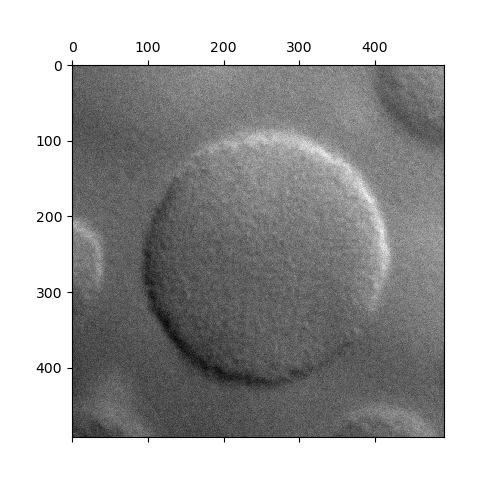

In [6]:
# Just to check things out, take a look at one of the images
%matplotlib notebook
image_number = 350 #this is the frame number we'll look at
plt.matshow(im[image_number], cmap=plt.cm.gray)

Next, we try filtering the image.

Before you go further, you should check out [this tutorial on image processing](http://scipy-lectures.org/advanced/image_processing/). In particular, pay close attention to the sections on image filtering and feature extraction. 

<IPython.core.display.Javascript object>


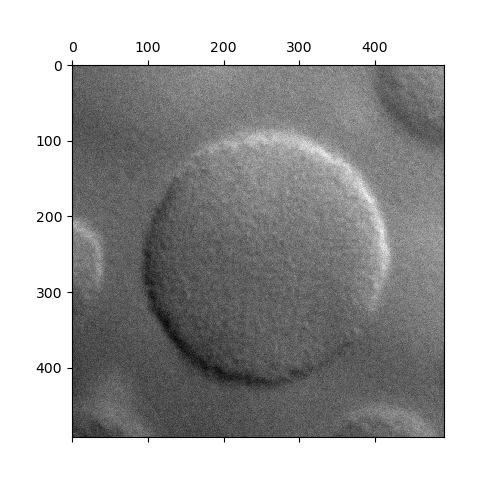

<IPython.core.display.Javascript object>


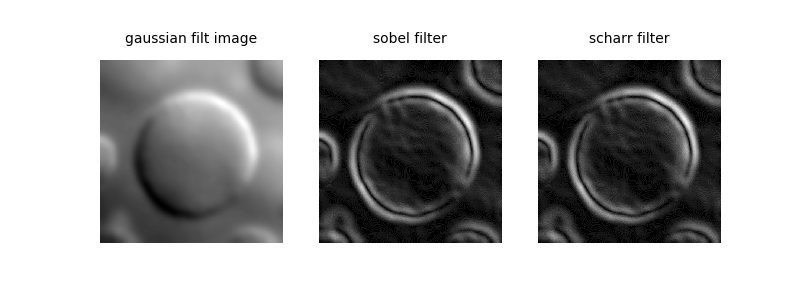

Text(0.5,1.05,'scharr filter')

In [7]:
#Let's make a copy of one of the frames so we can test some things out
image = im[image_number].copy()

#We'll show that image
plt.matshow(image, cmap=plt.cm.gray)

#Now, try filtering the images
#  We try: a Gaussian filter
#  And then, on top of that: a Sobel filter and a Scharr filter
filter_image_gauss = ndimage.gaussian_filter(image,9)
filter_image_sobel = sobel(filter_image_gauss)
filter_image_scharr = scharr(filter_image_gauss)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.matshow(filter_image_gauss, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('gaussian filt image', fontsize=10)

ax2.matshow(filter_image_sobel, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('sobel filter', fontsize=10)

ax3.matshow(filter_image_scharr, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('scharr filter', fontsize=10)

What we want to do is to locate the boundaries of our droplet. <br>
Let's stick with the Sobel filter and work more with that. 

<IPython.core.display.Javascript object>


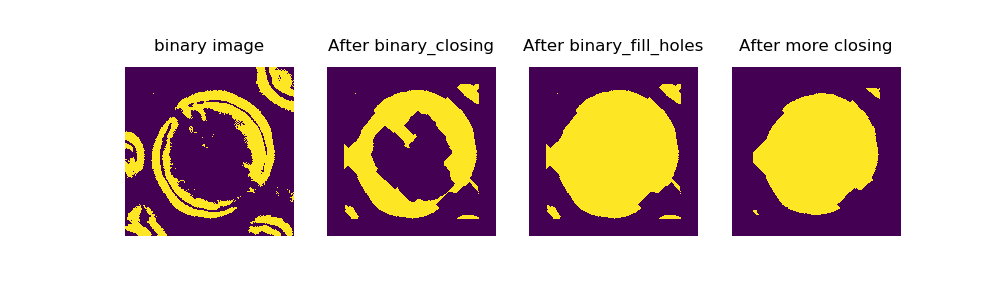

In [8]:
fig,ax = plt.subplots(1,4,figsize=(10,3))

blackwhite_threshold_fraction = 0.22 #Our threshold will be 22% of the maximum value
bw_threshold = blackwhite_threshold_fraction*filter_image_sobel.max()  
bw_image = filter_image_sobel>bw_threshold #turn image into binary (black/white) image
ax[0].matshow(bw_image)
ax[0].axis('off')
ax[0].set_title("binary image")

#Set the edge to zero (if bits of other droplets are shown at the edges, we want them gone)
edge = 50
value_to_replace = 0
bw_image[0:edge,:] = value_to_replace
bw_image[:,-edge:] = value_to_replace
bw_image[-edge:,:] = value_to_replace
bw_image[:,0:edge] = value_to_replace

#Use "binary closing". Number of "interations" can be adjusted
interations_b_closing = 26
bw_new = ndimage.morphology.binary_closing(bw_image,iterations=interations_b_closing)
ax[1].matshow(bw_new)
ax[1].axis('off')
ax[1].set_title("After binary_closing")

#Now use a 'fill_holes' operation
bw_new = ndimage.morphology.binary_fill_holes(bw_new)
ax[2].matshow(bw_new)
ax[2].axis('off')
ax[2].set_title("After binary_fill_holes")

#Finally, use "binary erosion". Number of "interations" can be adjusted
interations_b_erosion = 10 
bw_new = ndimage.morphology.binary_erosion(bw_new,iterations=interations_b_erosion)
ax[3].matshow(bw_new)
ax[3].axis('off')
ax[3].set_title("After more closing");

Based on the parameters you determine work best above, let's make a function that does all that. With this function, we can quickly process a series of images.

In [9]:
def generate_mask(image, gf_filter_size=9, bw_thresh_fraction=0.22,interations_b_closing=26,interations_b_erosion=10,
                 radius_fraction1 = 0.85, radius_fraction2 = 0.6):
    '''
    The parameters of this function:
        image: the 2D image to analyze
        gf_filter_size: size parameter for Gaussian filtering of image 
        bw_thresh_fraction: threshold fraction for getting binary image after Sobel filter
        interations_b_closing: iterations of binary closing operation
        interations_b_erosion: iterations of binary erosion operation
        radius_fraction1:
        radius_fraction2:
        
       
    '''

    ## The three lines were used at one time, but I don't think necessary
    #w = np.where(image<100)
    #w2 = np.where(image>0)
    #image[w] = image[w2].mean()

    filter_image = ndimage.gaussian_filter(image,gf_filter_size)

    filt1 = sobel(filter_image)
    
    bw_threshold = bw_thresh_fraction*filt1.max()
    bw_image = filt1>bw_threshold
    
    #Set the edge to zero (if bits of other droplets are shown at the edges, we want them gone)
    edge = 50
    value_to_replace = 0
    bw_image[0:edge,:] = value_to_replace
    bw_image[:,-edge:] = value_to_replace
    bw_image[-edge:,:] = value_to_replace
    bw_image[:,0:edge] = value_to_replace
    
    
    bw_new = ndimage.morphology.binary_closing(bw_image,iterations=interations_b_closing)

    bw_new = ndimage.morphology.binary_fill_holes(bw_new)

    bw_new = ndimage.morphology.binary_erosion(bw_new,iterations=interations_b_erosion)
    
    com = ndimage.center_of_mass(bw_new)
    radius = np.sqrt(bw_new.sum()/np.pi)
    
    xc = image.shape[0]/2
    yc = image.shape[1]/2

    ## this if-else checks if image is even or odd
    if im.shape[1] % 2:
        xx,yy = np.meshgrid(np.arange(-1*yc,yc+1,1)-com[1]+yc,np.arange(-1*xc,xc+1,1)-com[0]+xc)
    else:
        xx,yy = np.meshgrid(np.arange(-1*yc,yc,1)-com[1]+yc,np.arange(-1*xc,xc,1)-com[0]+xc)

    r = np.sqrt(xx**2 + yy**2)
    rmask = r<(radius_fraction1*radius) #was 0.85
    rmask2 = r<(radius_fraction2*radius)
    
    #distances = r - np.array([comx,comy])
    
    
    return bw_new, rmask, rmask2, radius, com


<IPython.core.display.Javascript object>


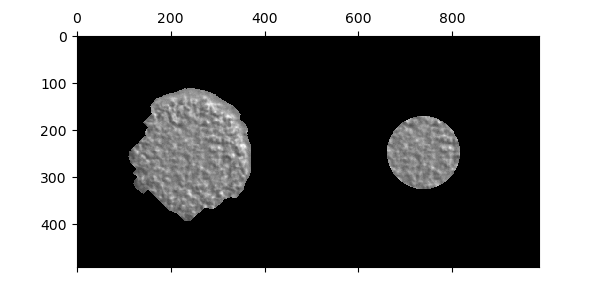

In [10]:
image_number = 410
mask, rmask, rmask2, rad, com = generate_mask(im[image_number])
plt.figure(figsize=(6,3))
plt.matshow(np.c_[im[image_number]*mask, im[image_number]*rmask2], cmap=cm.gray, fignum=False)

In [17]:
start = 350
end = 650

#first we initialize some arrays
im_matrix_new = im[start:end,:,:].copy()
just_mask = im[start:end,:,:].copy()
just_mask2 = im[start:end,:,:].copy()
radii = np.zeros((im_matrix_new.shape[0]))
centers_of_mass = np.zeros((im_matrix_new.shape[0],2))

#then, we'll look over the set of images (from frames `start' to `end')
for i in range(im_matrix_new.shape[0]):
    mask, rmask, rmask2, rad, com = generate_mask(im[start+i])
    im_matrix_new[i] = im[start+i]*rmask
    just_mask[i] = rmask
    just_mask2[i] = rmask2
    radii[i] = rad
    centers_of_mass[i] = com

In [18]:
print("Shape of 'im_matrix_new': ", im_matrix_new.shape)

("Shape of 'im_matrix_new': ", (300L, 492L, 492L))


<IPython.core.display.Javascript object>


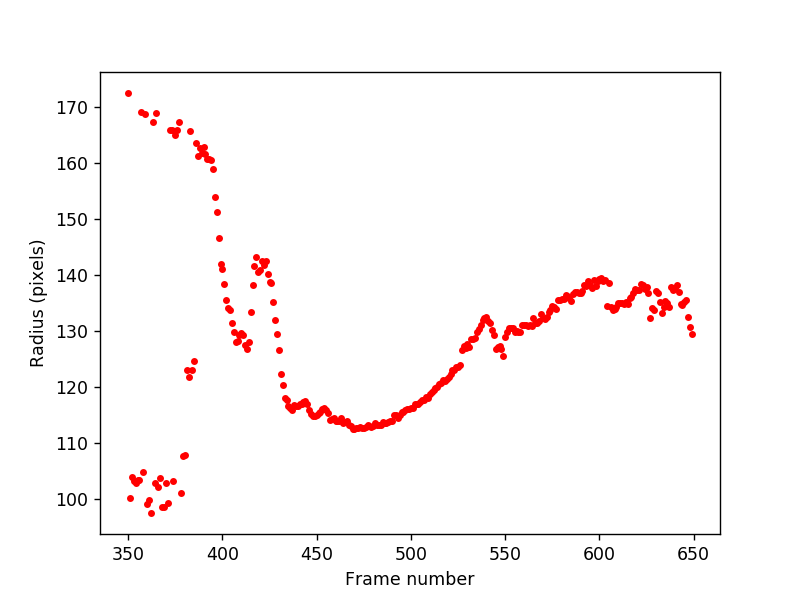

<IPython.core.display.Javascript object>


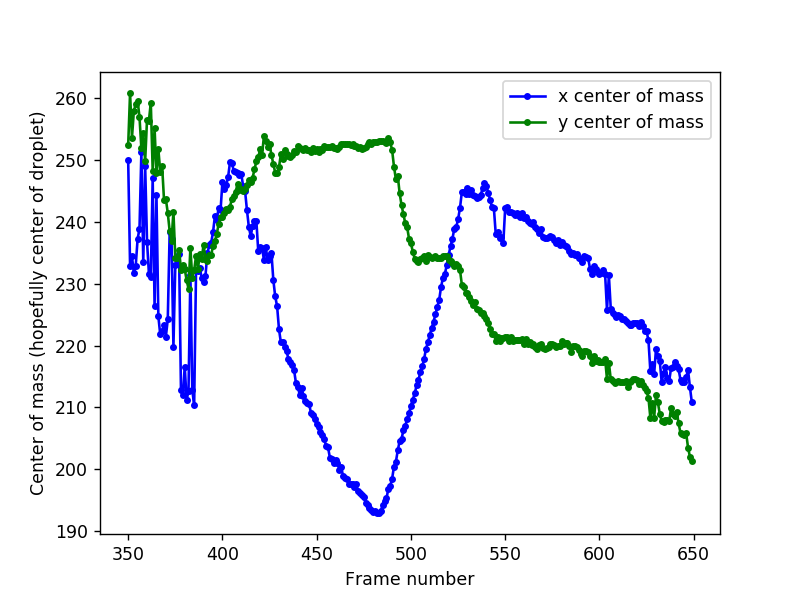

In [19]:
frames = np.arange(start,end)

plt.figure()
plt.plot(frames,radii,'r.')
plt.ylabel("Radius (pixels)")
plt.xlabel("Frame number")

plt.figure()
plt.plot(frames,centers_of_mass[:,0],'-b.',label="x center of mass")
plt.plot(frames,centers_of_mass[:,1],'-g.',label="y center of mass")
plt.ylabel("Center of mass (hopefully center of droplet)")
plt.xlabel("Frame number")
plt.legend()

In [20]:
## THIS WILL SAVE THE PROCESSED MOVIE IN YOUR CODE DIRECTORY!
tiff_file.imsave(data_file[:-4]+"_test.tif", im_matrix_new)

## Now to doing PIV work

You will likely need to install the Python package [numdifftools](https://numdifftools.readthedocs.io/en/latest/tutorials/install.html) for this to work. Check out that link for installation instructions. <br>

Most likely, all you will need to do is open up an Anaconda Prompt. Then just type: <br>
> `pip install numdifftools`
<br>

<br>You'll also need to install the Python package [openpiv](https://github.com/OpenPIV/openpiv-python). To install, you'll again open up an Anaconda Prompt and type: <br>
> `conda install -c conda-forge openpiv`

In [23]:
import numdifftools as nd
from openpiv import tools, process, scaling, pyprocess, validation, filters

### Here, we just test some things

We'll compare two images separated by just a couple to a few frames.

<IPython.core.display.Javascript object>


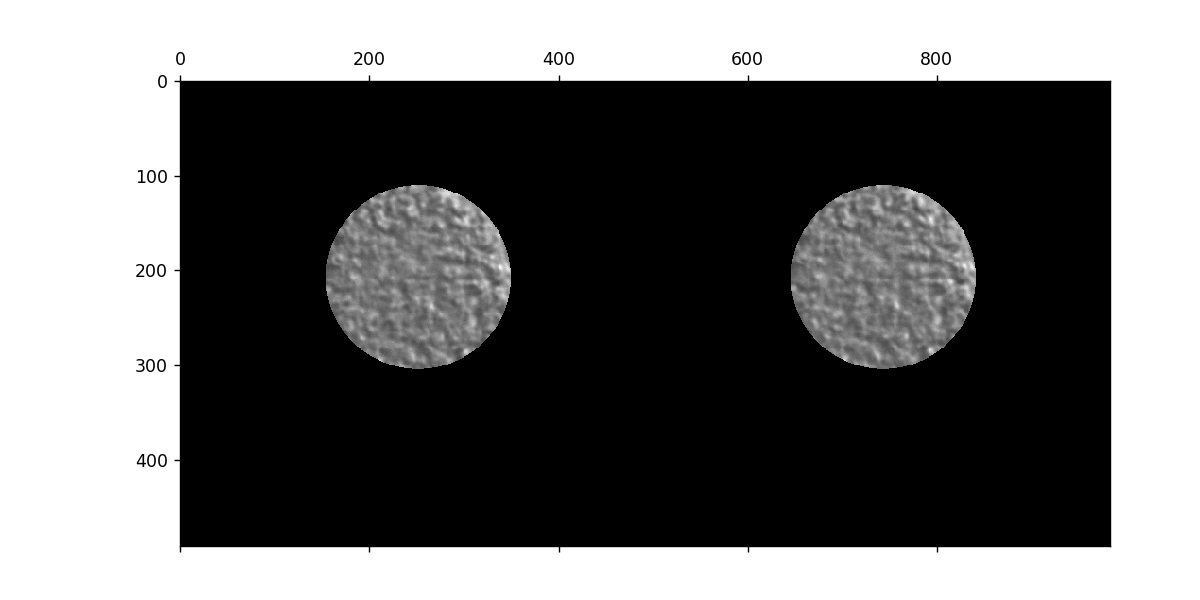

<IPython.core.display.Javascript object>


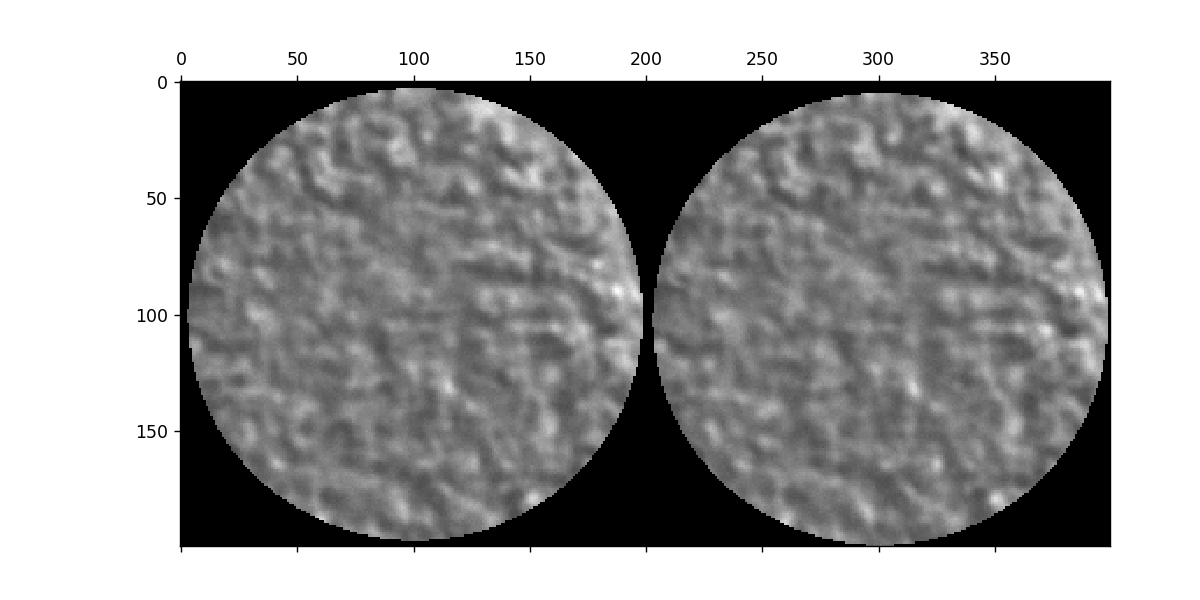

In [21]:
frame1 = 450
frame2 = 453

frame_index1 = frame1 - start
frame_index2 = frame2 - start

frame1 = im_matrix_new[frame_index1].copy().astype(np.float) * just_mask[frame_index1] * just_mask[frame_index2]
frame2 = im_matrix_new[frame_index2].copy().astype(np.float) * just_mask[frame_index1] * just_mask[frame_index2]
'''
w = np.where(frame1==0)
frame1[w] = np.nan
w = np.where(frame2==0)
frame2[w] = np.nan
'''
frame1_new = frame1[:,:]
frame2_new = frame2[:,:]

plt.matshow(np.c_[frame1_new,frame2_new], cmap=cm.gray) #'np.c_' concatonates two matrixes together


cx1 = np.int(centers_of_mass[frame_index1,0]); cy1 = np.int(centers_of_mass[frame_index1,1])
cx2 = np.int(centers_of_mass[frame_index2,0]); cy2 = np.int(centers_of_mass[frame_index2,1])
newsize=100
frame1_new2 = frame1[cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]
frame2_new2 = frame2[cx2-newsize:cx2+newsize,cy2-newsize:cy2+newsize]

plt.matshow(np.c_[frame1_new2,frame2_new2], cmap=cm.gray)

Here, we begin the PIV analysis.

In [24]:
winsize = 28 # pixels
searchsize = 36# pixels, search in image B
overlap = 18 # pixels
dt = 0.02 # sec


u0, v0, sig2noise = process.extended_search_area_piv(frame1_new.astype(np.int32), frame2_new.astype(np.int32),
                                                     window_size=winsize, overlap=overlap, dt=dt, 
                                                     search_area_size=searchsize, sig2noise_method='peak2peak' )
w = np.where(np.isfinite(sig2noise) == False)
sig2noise[w] = 1000

In [25]:
x, y = process.get_coordinates( image_size=frame1_new.shape, window_size=winsize, overlap=overlap )
u1, v1, mask = validation.sig2noise_val( u0.copy(), v0.copy(), sig2noise, threshold = 1.15 ) #threshold was 1.3
u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )

w_u3_0 = np.where(u3==0)
w_v3_0 = np.where(v3==0)

u3_mean = u3[abs(u3)>0].mean()
v3_mean = v3[abs(v3)>0].mean()

u3 = u3-u3_mean
v3 = v3-v3_mean
u3[w_u3_0] = 0
v3[w_v3_0] = 0

piv_vector_length = np.sqrt(u3**2 + v3**2)

<IPython.core.display.Javascript object>


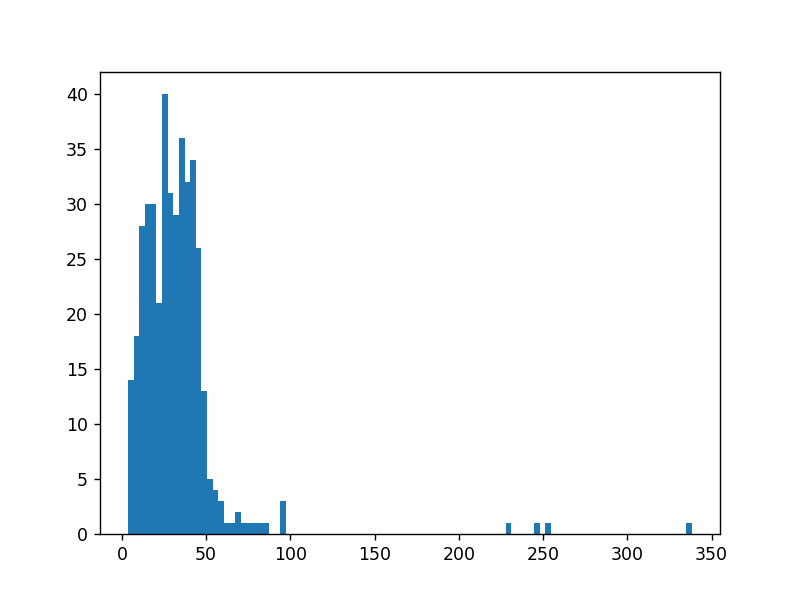

Mean PIV vector length: 32.5795
Std dev of PIV vector length: 28.1422


In [28]:
plt.figure()
w = np.where(piv_vector_length>0)
plt.hist(piv_vector_length[w].flatten(), bins=100)
print("Mean PIV vector length: %.4f" % piv_vector_length[w].mean())
print("Std dev of PIV vector length: %.4f" % piv_vector_length[w].std())

<IPython.core.display.Javascript object>


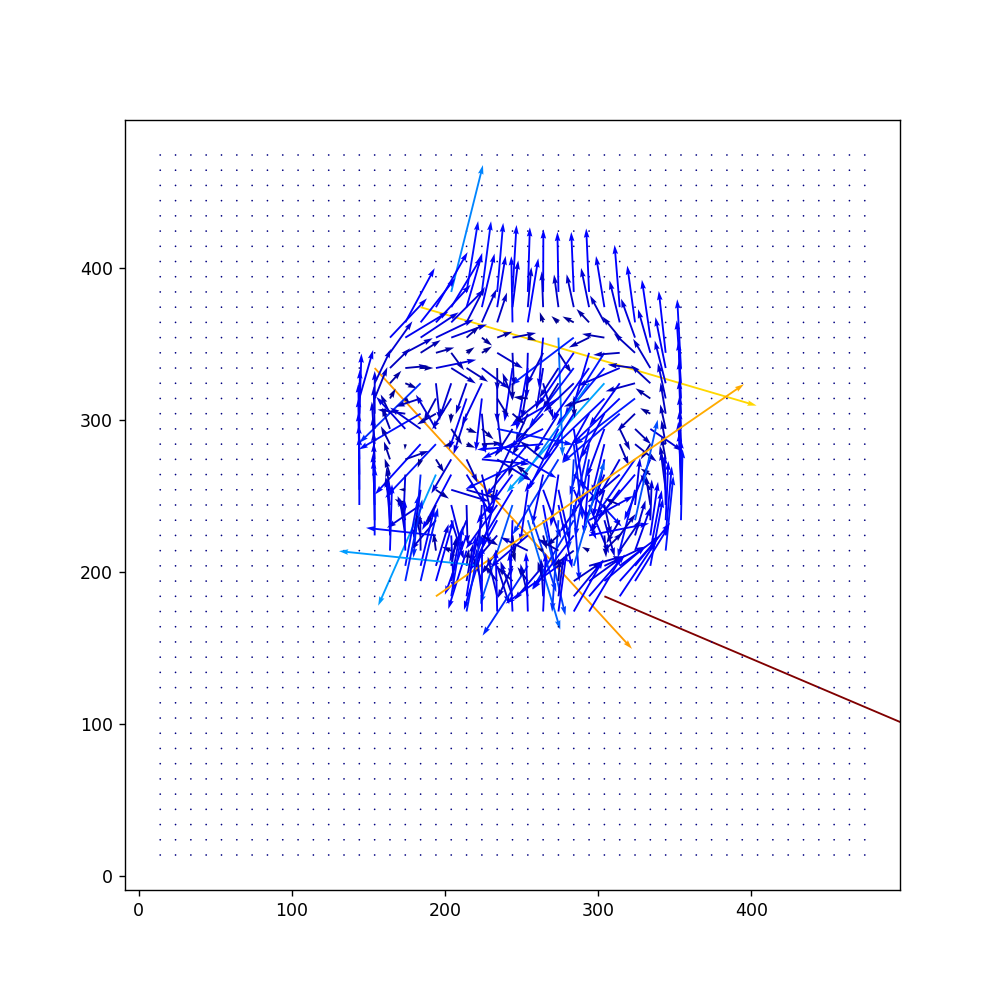

<IPython.core.display.Javascript object>


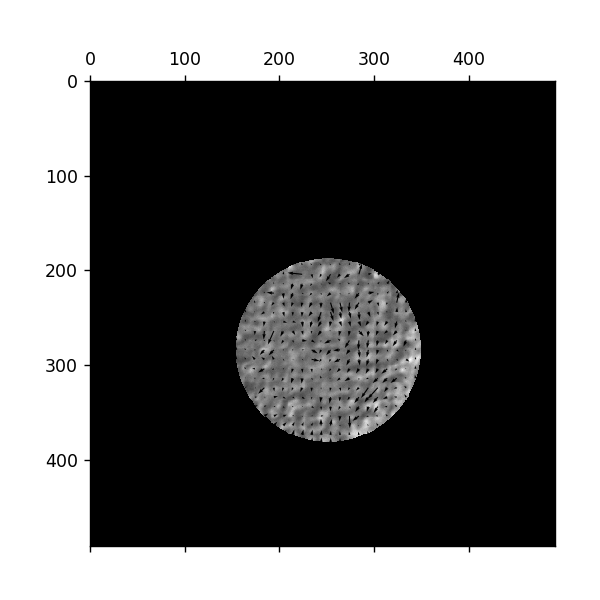

In [29]:
plot_every=1
plt.figure(figsize=(8,8))
plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
           1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
           np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
           cmap=cm.jet)
plot_every = 1
plt.matshow(np.flipud(frame1_new),cmap=cm.gray)
plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
           1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],scale=3000)

In [37]:
def generate_vector_field(frame_index1, frame_index2, im_matrix_new, just_mask, just_mask2, centers_of_mass,
                         winsize=28, searchsize=36, overlap=22, dt=0.02, clearaxes=True, tosave=True):
    frame1 = im_matrix_new[frame_index1].copy().astype(np.float) * just_mask[frame_index1] * just_mask[frame_index2]
    frame2 = im_matrix_new[frame_index2].copy().astype(np.float) * just_mask[frame_index1] * just_mask[frame_index2]
    
    cx1 = np.int(centers_of_mass[frame_index1,0]); cy1 = np.int(centers_of_mass[frame_index1,1])
    cx2 = np.int(centers_of_mass[frame_index2,0]); cy2 = np.int(centers_of_mass[frame_index2,1])
    newsize=100
    frame1_new2 = frame1[cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]
    frame2_new2 = frame2[cx2-newsize:cx2+newsize,cy2-newsize:cy2+newsize]
    
    

    u0, v0, sig2noise = process.extended_search_area_piv(frame1_new2.astype(np.int32), frame2_new2.astype(np.int32),
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize, sig2noise_method='peak2peak' )
    w = np.where(np.isfinite(sig2noise) == False)
    sig2noise[w] = 1000
    
    x, y = process.get_coordinates( image_size=frame1_new2.shape, window_size=winsize, overlap=overlap )
    u1, v1, mask = validation.sig2noise_val( u0.copy(), v0.copy(), sig2noise, threshold = 1.15 ) #threshold was 1.3
    u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )
    
    
    piv_vector_length = np.sqrt(u3**2 + v3**2)
    w = np.where(piv_vector_length>0)
    piv_length_mean = piv_vector_length[w].mean()
    piv_length_std = piv_vector_length[w].std()
    w = np.where(piv_vector_length > (piv_length_mean+2*piv_length_std))
    v3[w]=0
    u3[w]=0
    
    plot_every = 1
    plt.matshow(np.flipud(frame1_new2),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=3000)
    if tosave:
        plt.savefig("Z:\\JackBrady_F19\\Code\\RJM Fields\\v2\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
        
    
    
    just_mask2_new1 = just_mask2[frame_index1, cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]
    just_mask2_new2 = just_mask2[frame_index2, cx2-newsize:cx2+newsize,cy2-newsize:cy2+newsize]
    
    just_mask2_combo = just_mask2_new1 * just_mask2_new2
    
    #Getting div...
    new_mask2 = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            xcoord = np.int(x[i,j])
            ycoord = np.int(y[i,j])
            if xcoord<just_mask2.shape[1]:
                if ycoord<just_mask2.shape[2]:
                    if just_mask2_combo[xcoord,ycoord]>0:
                        new_mask2[i,j]=1
                        
                        
    u3 = u3*new_mask2
    v3 = v3*new_mask2
    '''This here is for removing drift'''
    w_u3_0 = np.where(u3==0)
    w_v3_0 = np.where(v3==0)

    u3_mean = u3[abs(u3)>0].mean()
    v3_mean = v3[abs(v3)>0].mean()

    u3 = u3-u3_mean
    v3 = v3-v3_mean
    u3[w_u3_0] = 0
    v3[w_v3_0] = 0
    '''Done with drift removal'''
    
    dudx = u3[1:,:]-u3[:-1,:]
    dudy = u3[:,1:]-u3[:,:-1]
    dvdx = v3[1:,:]-v3[:-1,:]
    dvdy = v3[:,1:]-v3[:,:-1]
    div = dudy[1:,:]-dvdx[:,1:]
    new_div = div*new_mask2[1:,1:]
    w = np.where(abs(new_div)>0)
    div_median = np.median(new_div[w])
    
    
    curl = dudx[:,1:]+dvdy[1:,:]
    new_curl = curl*new_mask2[1:,1:]
    w = np.where(abs(new_curl)>0)
    curl_median = np.median(new_curl[w])
    curl_rms = np.mean(new_curl[w]**2)
    curl_std = np.std(new_curl[w])
        
    return x,y,u3,v3,piv_vector_length, div_median, curl_median, curl_rms, curl_std

<IPython.core.display.Javascript object>


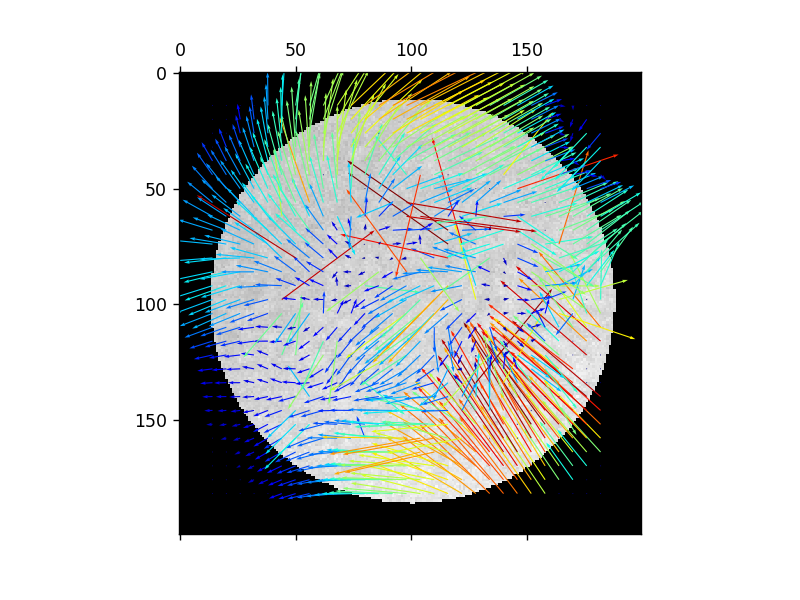

('Shape of u3 is: ', (29L, 29L))


In [38]:
plt.figure()
index=20
step = 3 #was 10
x,y,u3,v3,pvl, div, clm, clrms, clstd = generate_vector_field(index,index+step,im_matrix_new,just_mask, 
                                                              just_mask2, centers_of_mass, clearaxes=False, tosave=False);
print("Shape of u3 is: ", u3.shape)

In [97]:
print("Start and end: ", (start,end))

('Start and end: ', (350, 650))


In [98]:
print("Shape of im_mtrix_new: ", im_matrix_new.shape)

('Shape of im_mtrix_new: ', (300L, 492L, 492L))


<IPython.core.display.Javascript object>


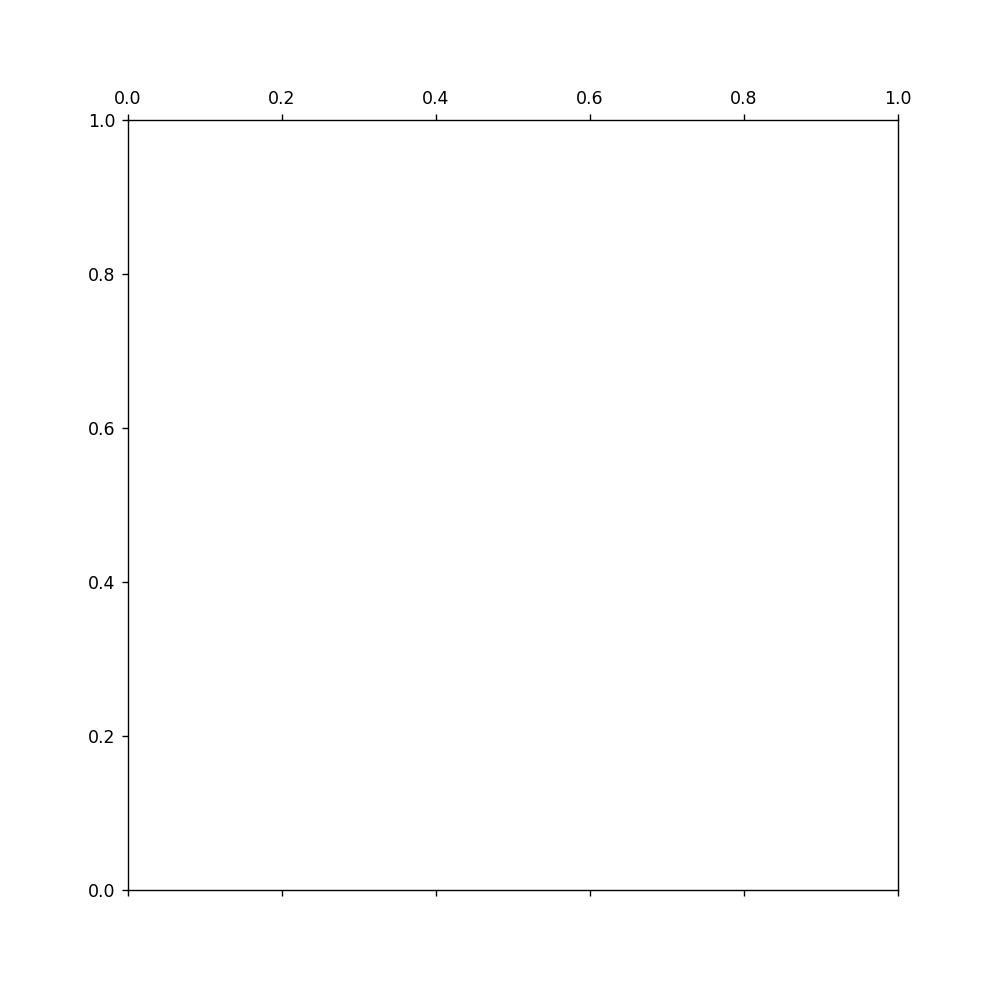

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [39]:
##Looping through all frames...


step=3
indices = np.arange(0,end-start-step,1)
divs = np.zeros_like(indices)*1.0
clms = np.zeros_like(divs)
clrms = np.zeros_like(clms)
clstds = np.zeros_like(clms)

plt.figure(figsize=(8,8))
j=0
for i in indices:
    x,y,u3,v3,pvl, divs[j], clms[j], clrms[j], clstds[j] = generate_vector_field(i,i+step,im_matrix_new,just_mask, 
                                                                                 just_mask2, centers_of_mass,
                                                                                 tosave=False)
    j=j+1

<IPython.core.display.Javascript object>


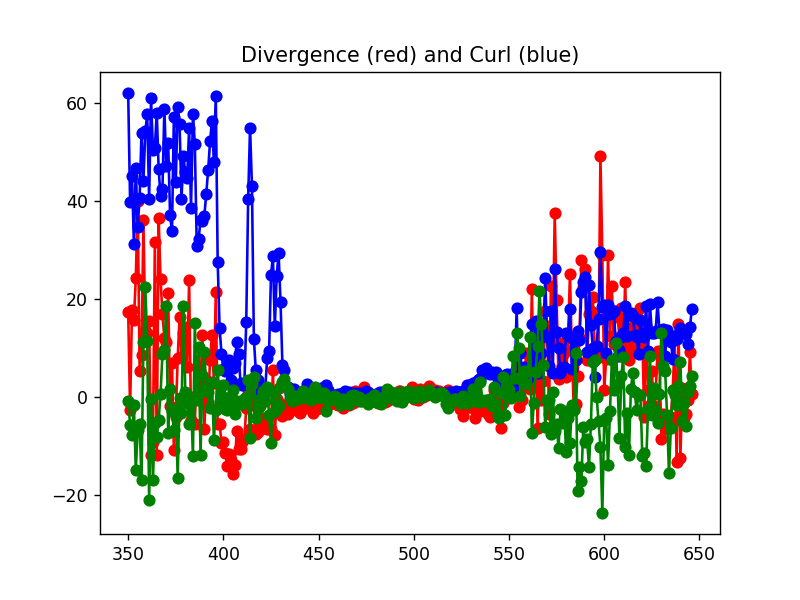

Text(0.5,1,'Divergence (red) and Curl (blue)')

In [40]:
plt.figure()
plt.plot(frames[indices],divs,'-ro')
plt.plot(frames[indices],0.2*clrms**0.5 - 2.07,'-bo')
plt.plot(frames[indices],clms,'-go')
plt.title("Divergence (red) and Curl (blue)")

<IPython.core.display.Javascript object>


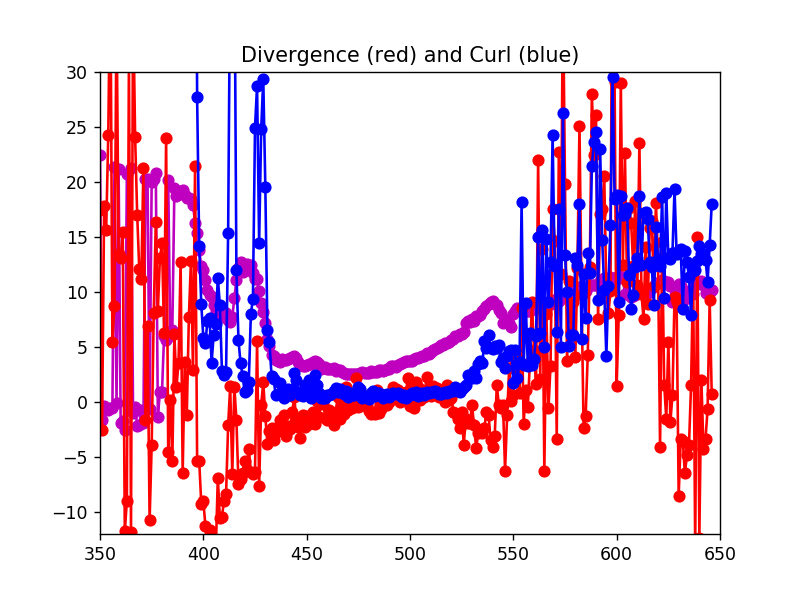

In [41]:
plt.figure()
plt.plot(frames[indices],radii[indices]/3.0 - 35,'-mo')
plt.plot(frames[indices],divs,'-ro')
plt.plot(frames[indices],0.2*clrms**0.5 - 2.07,'-bo')
#plt.plot(indices,clstds,'-go')
plt.title("Divergence (red) and Curl (blue)")
#plt.axvline(365,c='k',lw=4,alpha=0.4)
#plt.axvline(601,c='k',lw=4,alpha=0.4)
plt.xlim(350,650)
plt.ylim(-12,30)
plt.savefig(data_directory+data_file[:-4]+"_StepOf1_CalcEvery1Frame.png")

In [39]:
#From frames 408 to 436, there seems to be changes in focus
num_frames_to_discard = 436-407
print("Number of frames to discard: %i" % num_frames_to_discard)
w = np.where(frames[indices]==407)
print("Frame 408 corresponds to %i." % w[0][0])

Number of frames to discard: 29
Frame 408 corresponds to 57.


In [42]:
clrms_new = clrms.copy()
clrms_new[57:57+num_frames_to_discard]=np.nan
radii_new = radii[indices].copy()
radii_new[57:57+num_frames_to_discard]=np.nan

<IPython.core.display.Javascript object>


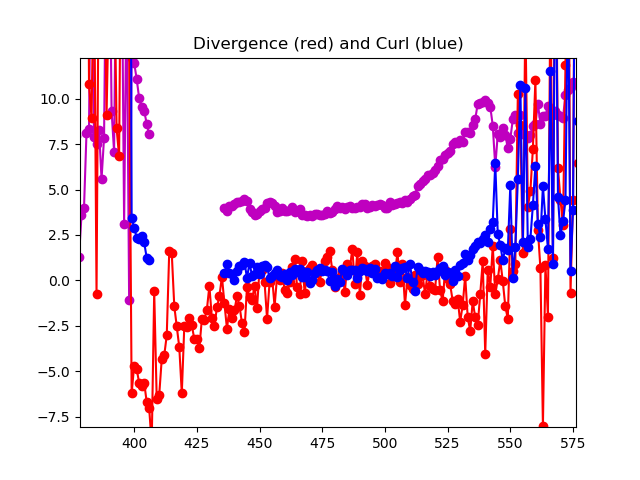

(-12, 30)

In [44]:
plt.figure()
plt.plot(frames[indices],radii_new/3.0 - 35,'-mo')
plt.plot(frames[indices],divs,'-ro')
plt.plot(frames[indices],0.2*clrms_new**0.5 - 2.07,'-bo')
#plt.plot(indices,clstds,'-go')
plt.title("Divergence (red) and Curl (blue)")
#plt.axvline(365,c='k',lw=4,alpha=0.4)
#plt.axvline(601,c='k',lw=4,alpha=0.4)
plt.xlim(350,650)
plt.ylim(-12,30)

In [81]:
w = np.where(clrms>800)
clrms_new = clrms.copy()
for i in range(1,len(w[0])-1):
    clrms_new[w[0][i]] = np.median(clrms[w[0][i]-3:w[0][i]+4])

C:\Users\RMCGORTY\AppData\Local\Continuum\anaconda2\envs\cody\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\RMCGORTY\AppData\Local\Continuum\anaconda2\envs\cody\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


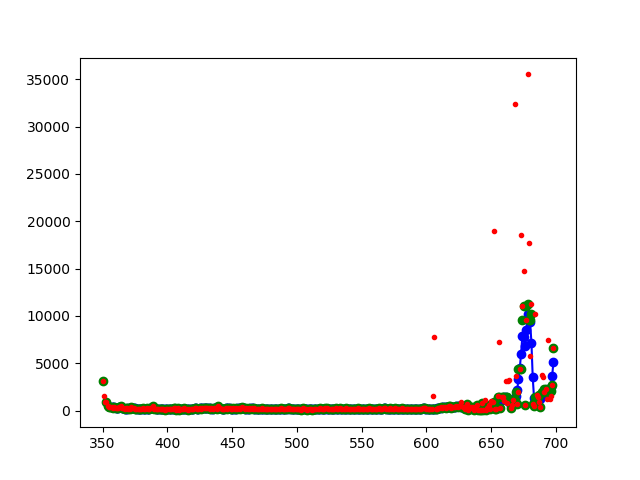

In [87]:
plt.figure()
plt.plot(frames[indices],ndimage.gaussian_filter1d(clrms_new,1),'-bo')
plt.plot(frames[indices],clrms_new,'go')
plt.plot(frames[indices],clrms,'r.')

<IPython.core.display.Javascript object>


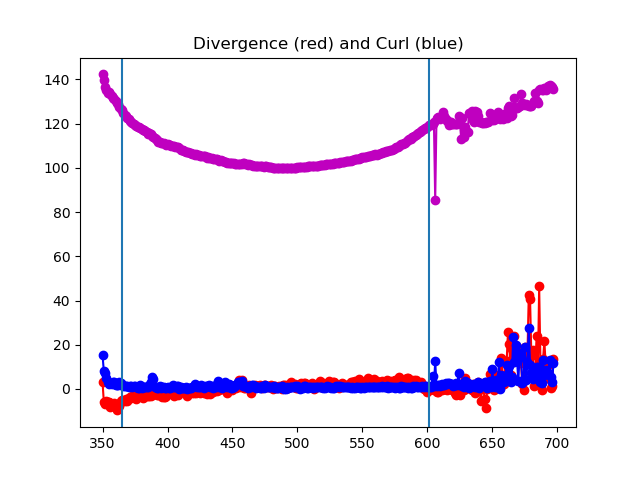

In [66]:
plt.figure()
plt.plot(frames[indices],radii[indices],'-mo')
plt.plot(frames[indices],divs,'-ro')
plt.plot(frames[indices],0.2*clrms**0.5 - 2.07,'-bo')
#plt.plot(indices,clstds,'-go')
plt.title("Divergence (red) and Curl (blue)")
plt.axvline(365)
plt.axvline(601)

<IPython.core.display.Javascript object>


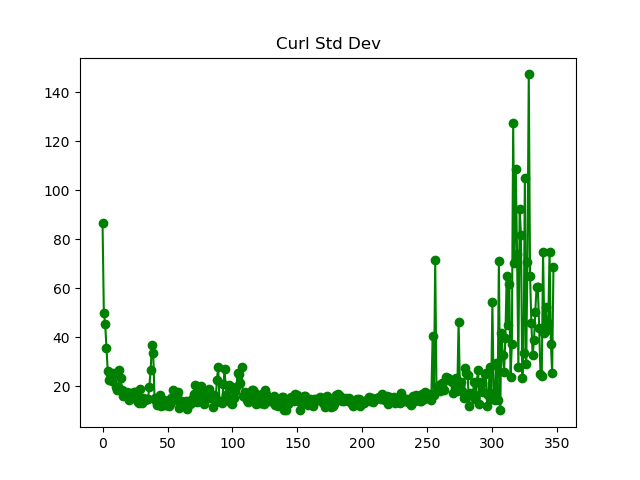

Text(0.5,1,'Curl Std Dev')

In [67]:
plt.figure()
plt.plot(indices,clstds,'-go')
plt.title("Curl Std Dev")

In [571]:
clms.dtype

dtype('int32')